In [302]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# All functions

In [308]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = len(x)

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [309]:
def createTrain(X_train, y_train, task):
    '''
    Given training features and labels, returns Dataset depending on the task
    '''
    X_train = torch.tensor(X_train).float()
    mean = torch.mean(X_train, dim=0)
    std = torch.std(X_train, dim=0)
    X_train = (X_train - mean) / std

    indices = []
    if len(torch.where(torch.isnan(X_train[0]))[0].numpy()) != 0:
        indices = torch.where(torch.isnan(X_train[0]))[0].numpy()
        for idx in indices:
            X_train[:, idx] = 0.0
    
    if (task == 'classification1') or (task == 'classification2'):
        y_train = torch.tensor(y_train).long()
    elif task == 'regression':
        y_train = torch.tensor(y_train).reshape(-1, 1).float()

    return Dataset(X_train, y_train), [mean, std, indices]


def createValTest(X_val, X_test, y_val, y_test, parameters, task):
    '''
    Given validation and test features, and  validation and test labels, returns Dataset depending on the task
    '''
    X_val = (torch.tensor(X_val).float() - parameters[0]) / parameters[1]
    X_test = (torch.tensor(X_test).float() - parameters[0]) / parameters[1]

    if len(parameters[2]) != 0:
        for idx in parameters[2]:
            X_val[:, idx] = 0.0
            X_test[:, idx] = 0.0
    
    if (task == 'classification1') or (task == 'classification2'):
        y_val = torch.tensor(y_val).long()
        y_test = torch.tensor(y_test).long()
    elif task == 'regression':
        y_val = torch.tensor(y_val).reshape(-1, 1).long()
        y_test = torch.tensor(y_test).reshape(-1, 1).float()

    return Dataset(X_val, y_val), Dataset(X_test, y_test)


def read_split(file, task):
    '''
    Given filename of data and task, returns the train, validation and test Datasets
    '''
    df = pd.read_csv(file)
    if task == 'classification1':
        X = df.iloc[:, 2:-2].values
        y = df.iloc[:, -2].values
    elif task == 'classification2':
        draftOrUndraft = np.zeros(shape=(df.shape[0], 1))
        for i, val in enumerate(df['DraftCategory'].values):
            if val == 4:
                draftOrUndraft[i] = 1
            else:
                draftOrUndraft[i] = 0
        df['DraftCategory'] = draftOrUndraft
        X = df.iloc[:, 2:-2].values
        y = df.iloc[:, -2].values
    elif task == 'regression':
        df = df[df['DraftCategory'] != 4]
        X = df.iloc[:, 2:-2].values
        y = df.iloc[:, -1].values
    else:
        return 0

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    train_ds, parameters = createTrain(X_train, y_train, task)
    val_ds, test_ds = createValTest(X_val, X_test, y_val, y_test, parameters, task)
    return train_ds, val_ds, test_ds

In [310]:
class ClassificationNet(nn.Module):
    '''
    NN for the classification tasks
    Utilises ReLU as activation function
    Dropout can be adjusted
    '''
    def __init__(self, Layers):
        super(ClassificationNet, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.dropout(F.relu(linear_transform(activation)), p=0.5)
            else:
                activation = linear_transform(activation)
        return activation


class RegressionNet(nn.Module):
    '''
    NN for the regression task
    Utilises ReLU as activation function
    Dropout can be adjusted
    '''
    def __init__(self, Layers):
        super(RegressionNet, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.dropout(F.relu(linear_transform(activation)), p=0)
            else:
                activation = linear_transform(activation)
        return activation

In [318]:
def train(mdl, criterion, train_loader, train_ds, val_ds, metric, optimizer, epochs=100):
    '''
    Trains the model and records train loss and validation loss at end of each epoch
    Also records the train accuracy/MAE and validation accuracy/MAE at end of each epoch
    '''
    train_loss = []
    val_loss = []
    train_metric = []
    val_metric = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = mdl(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
        train_loss.append(criterion(mdl(train_ds.x), train_ds.y).item())
        val_loss.append(criterion(mdl(val_ds.x), val_ds.y).item())
        train_metric.append(metric(mdl, train_ds))
        val_metric.append(metric(mdl, val_ds))
    
    return train_loss, val_loss, train_metric, val_metric

In [312]:
torch.manual_seed(1)

def accuracy(mdl, ds):
    '''
    Metric used for the classification tasks
    '''
    _, yhat = torch.max(mdl(ds.x), 1)
    return (yhat == ds.y).numpy().mean()


def mae(mdl, ds):
    '''
    Metric used for the regression task
    '''
    total = 0
    for i in range(len(ds.x)):
        total += F.l1_loss(mdl(ds.x[i]), ds.y[i]).item()
    return total / len(ds.x)

# 1. Finding best parameters for Classification 1
*Predicting whether a player will be drafted within the Top 15, Top 30, Top 45, Top 60 or Undrafted*

In [416]:
def classification1(Layers, batch_size, epochs):
    '''
    For the first classification task
    Layers, batch_size and epochs can be adjusted
    '''
    train_ds, val_ds, test_ds = read_split('data/secondMost.csv', 'classification1')
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    mdl = ClassificationNet(Layers)
    optimizer = torch.optim.Adam(mdl.parameters())
    criterion = nn.CrossEntropyLoss()
    train_loss, val_loss, train_metric, val_metric =\
        train(mdl, criterion, train_loader, train_ds, val_ds, accuracy, optimizer, epochs=epochs)
    
    
    f = plt.figure(figsize=(20,5))
    ax = plt.subplot('121')
    ax.set_title('Loss against Epochs')
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')

    ax = plt.subplot('122')
    ax.set_title('Accuracy against Epochs')
    ax.plot(train_metric)
    ax.plot(val_metric)

    f.legend(fontsize=15, loc=7)
    
    return mdl, test_ds

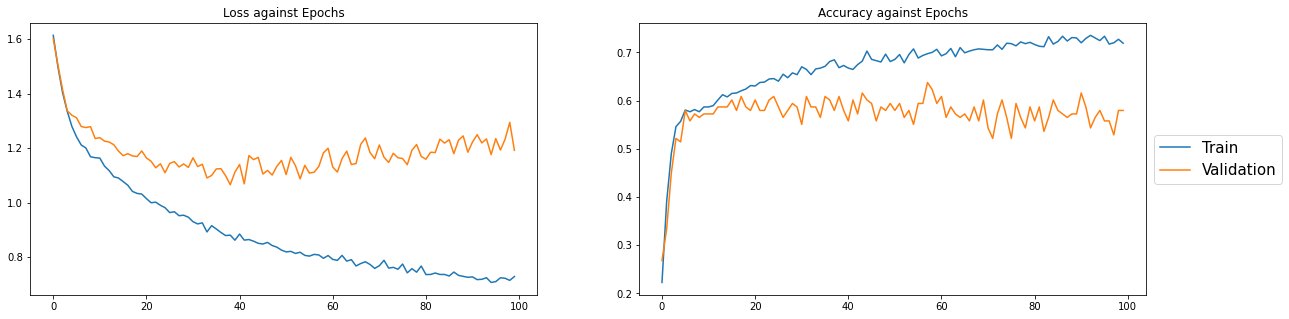

In [417]:
mdl, test_ds = classification1([75, 100, 5], 256, 100)

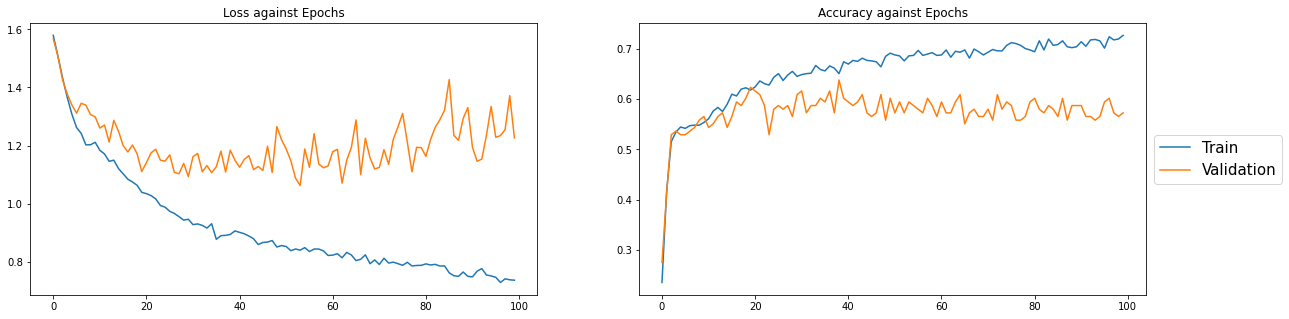

In [375]:
mdl, test_ds = classification1([75, 100, 50, 5], 256, 100)

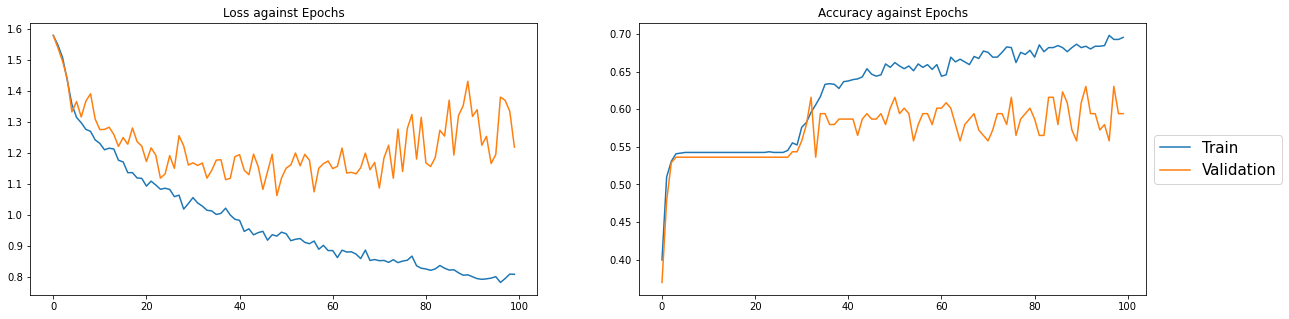

In [374]:
mdl, test_ds =  classification1([75, 100, 100, 50, 50, 5], 256, 100)

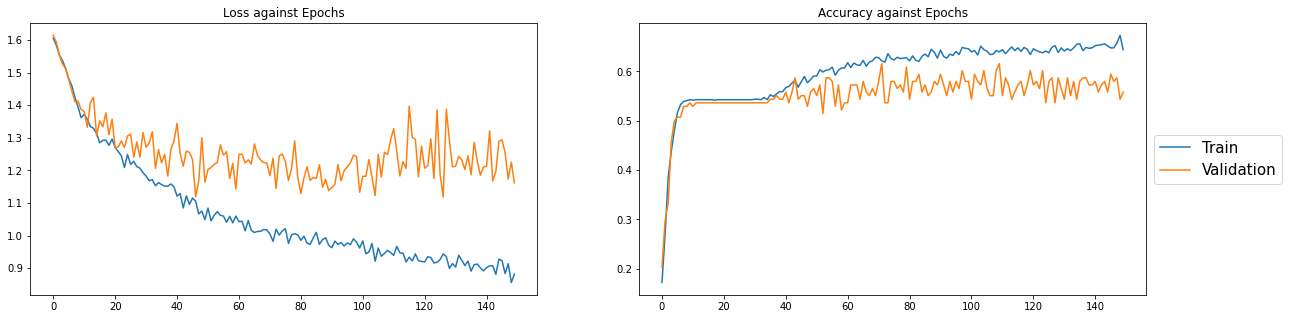

In [408]:
mdl, test_ds = classification1([75, 50, 25, 10, 25, 50, 5], 256, 150)

**We can see that accuracy is relatively poor, flucatuating between 55%-60% for the different models train on different sets of parameters.**

**We can pick a model and look at the precision and recall and see if there are any good results.**

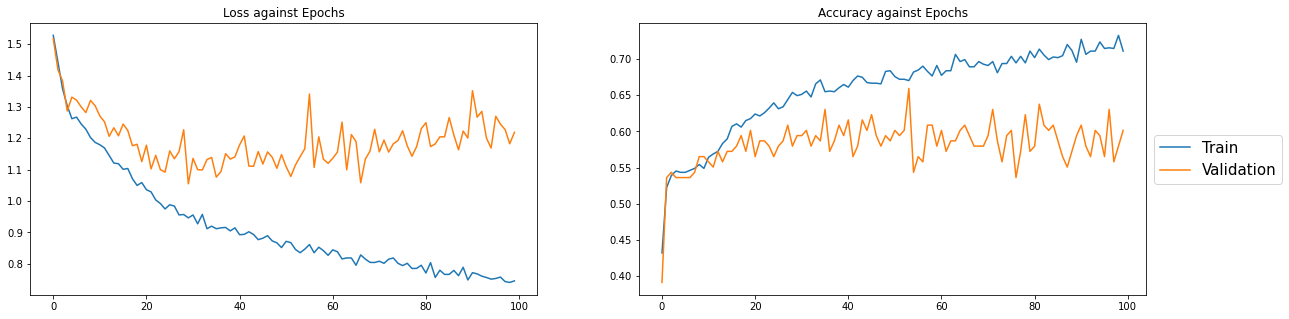

In [418]:
mdl, test_ds = classification1([75, 100, 50, 5], 256, 100)

In [432]:
print(classification_report(test_ds.y, torch.max(mdl(test_ds.x), 1)[1], 
                            target_names = ['1-15', '16-30', '31-45', '46-60', 'Undrafted']))

              precision    recall  f1-score   support

        1-15       0.72      0.62      0.67        21
       16-30       0.14      0.22      0.17         9
       31-45       0.25      0.07      0.11        15
       46-60       0.00      0.00      0.00        17
   Undrafted       0.69      0.89      0.78        76

    accuracy                           0.61       138
   macro avg       0.36      0.36      0.34       138
weighted avg       0.52      0.61      0.55       138



The model is unable to differentiate between the drafted players. For undrafted players, results are decent.

**Try an easier classification task.**

# 2. Finding best parameters for Classification 2
*Predicting whether a player will be Drafted or Undrafted*

In [434]:
def classification2(Layers, batch_size, epochs):
    '''
    For the second classification task
    Layers, batch_size and epochs can be adjusted
    '''
    train_ds, val_ds, test_ds = read_split('data/secondMost.csv', 'classification2')
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    mdl = ClassificationNet(Layers)
    optimizer = torch.optim.Adam(mdl.parameters())
    criterion = nn.CrossEntropyLoss()
    train_loss, val_loss, train_metric, val_metric =\
        train(mdl, criterion, train_loader, train_ds, val_ds, accuracy, optimizer, epochs=epochs)
    
    
    f = plt.figure(figsize=(20,5))
    ax = plt.subplot('121')
    ax.set_title('Loss against Epochs')
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')

    ax = plt.subplot('122')
    ax.set_title('Accuracy against Epochs')
    ax.plot(train_metric)
    ax.plot(val_metric)

    f.legend(fontsize=15, loc=7)
    
    return mdl, test_ds

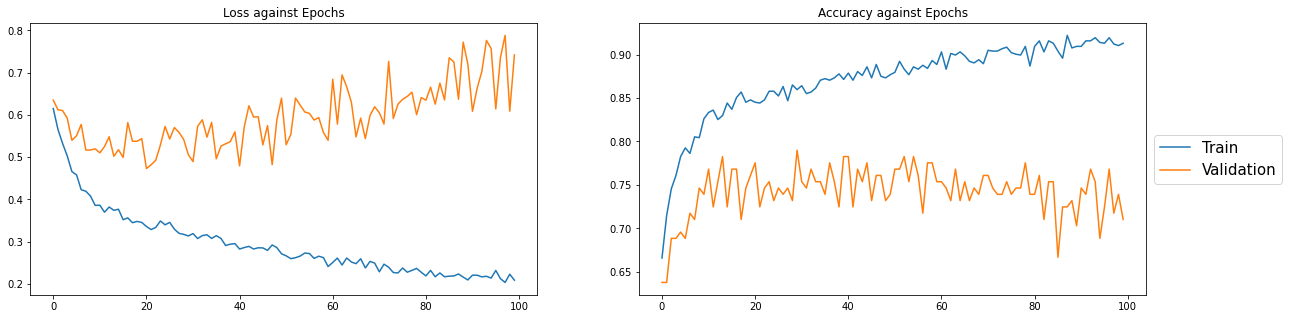

In [393]:
mdl, test_ds = classification2([75, 100, 2], 64, 100)

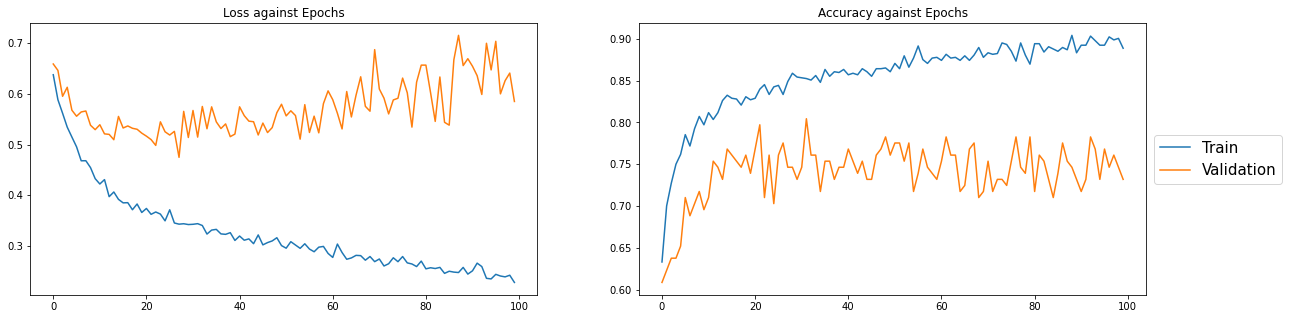

In [395]:
mdl, test_ds = classification2([75, 100, 2], 128, 100)

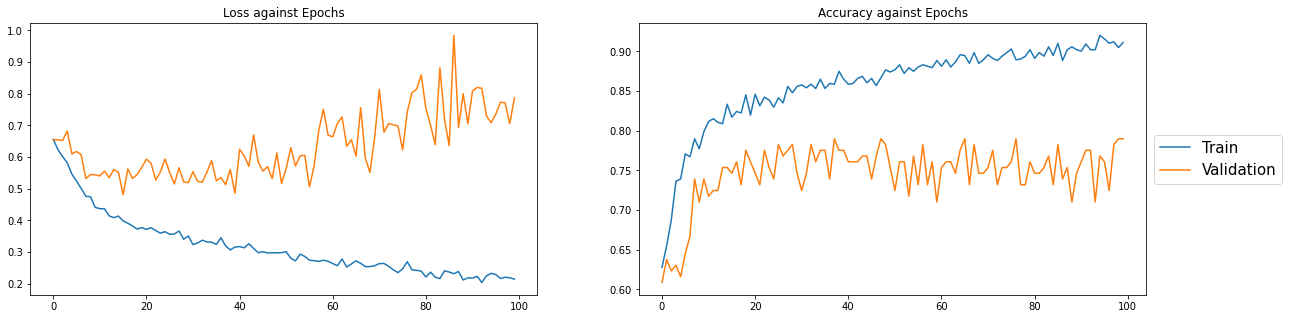

In [396]:
mdl, test_ds = classification2([75, 100, 50, 2], 128, 100)

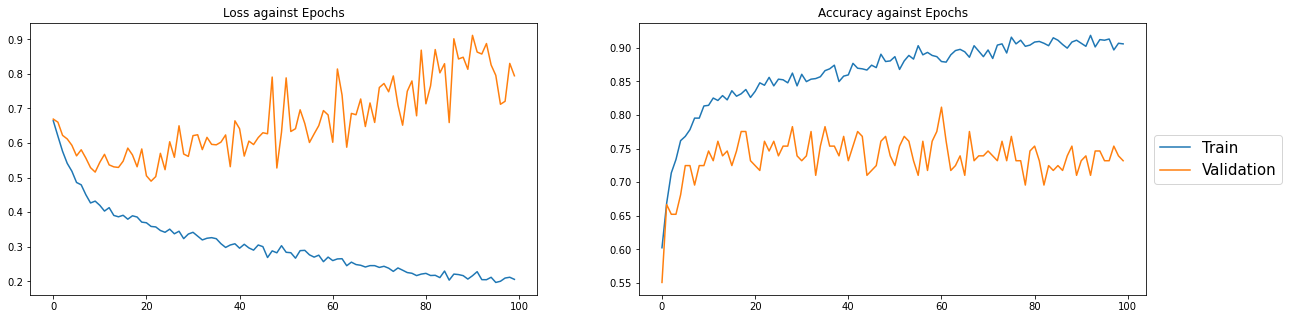

In [398]:
mdl, test_ds = classification2([75, 100, 100, 2], 128, 100)

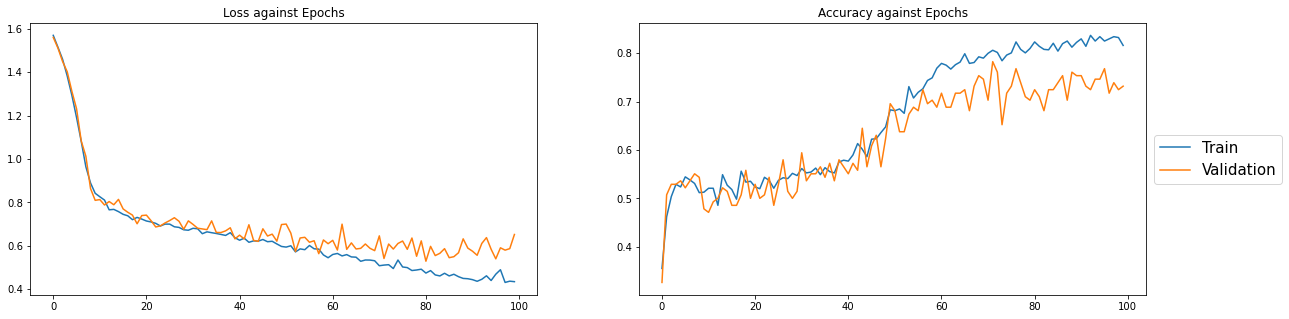

In [400]:
mdl, test_ds = classification2([75, 50, 25, 10, 25, 50, 5], 256, 100)

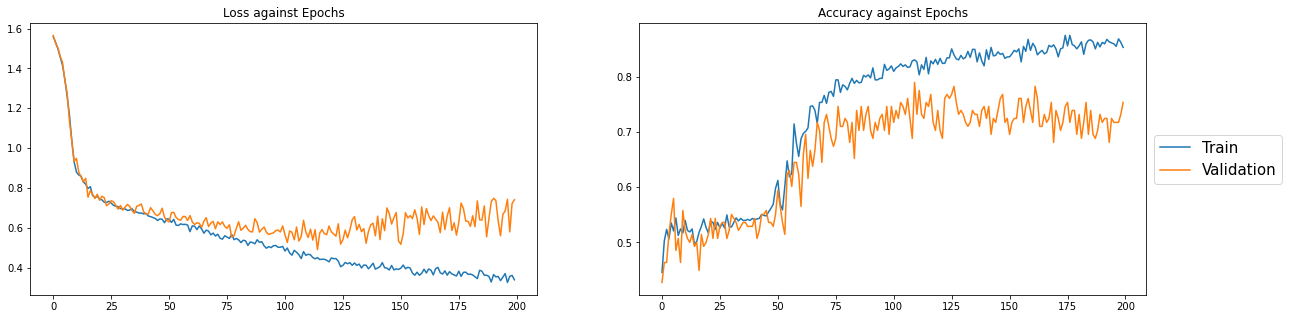

In [401]:
mdl, test_ds = classification2([75, 50, 25, 10, 25, 50, 5], 256, 200)

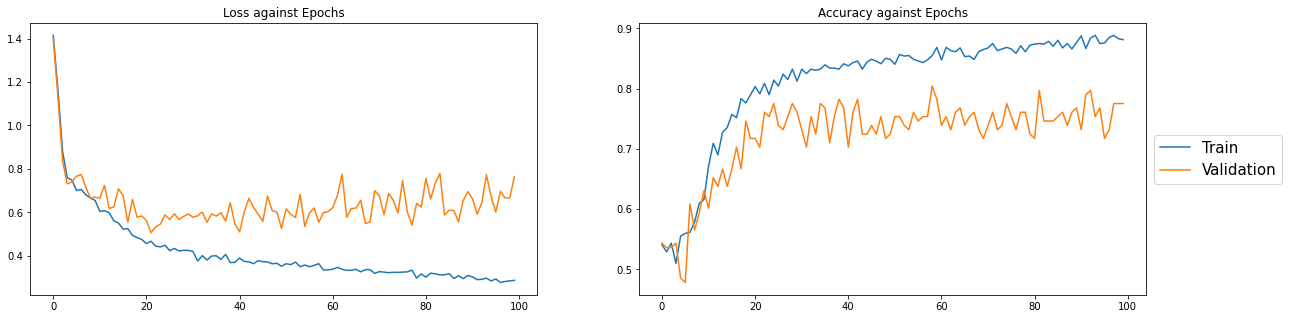

In [435]:
mdl, test_ds = classification2([75, 100, 100, 100, 100, 5], 256, 100)

**The results is better because the classification task is easier.**

In [436]:
print(classification_report(test_ds.y, torch.max(mdl(test_ds.x), 1)[1], 
                            target_names = ['Drafted', 'Undrafted']))

              precision    recall  f1-score   support

     Drafted       0.72      0.55      0.62        62
   Undrafted       0.69      0.83      0.75        76

    accuracy                           0.70       138
   macro avg       0.71      0.69      0.69       138
weighted avg       0.71      0.70      0.70       138



# 3. Finding best parameters for Regression
*Predicting the draft position of a drafted player*

In [445]:
def regression(Layers, batch_size, epochs):
    '''
    For the regression task
    Layers, batch_size and epochs can be adjusted
    '''
    train_ds, val_ds, test_ds = read_split('data/secondMost.csv', 'regression')
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    mdl = RegressionNet(Layers)
    optimizer = torch.optim.Adam(mdl.parameters())
    criterion = nn.SmoothL1Loss()
    train_loss, val_loss, train_metric, val_metric =\
        train(mdl, criterion, train_loader, train_ds, val_ds, mae, optimizer, epochs=epochs)
    f = plt.figure(figsize=(20,5))
    ax = plt.subplot('121')
    ax.set_title('Loss against Epochs')
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')

    ax = plt.subplot('122')
    ax.set_title('Mean Absolute Error against Epochs')
    ax.plot(train_metric)
    ax.plot(val_metric)
    
    f.legend(fontsize=15, loc=7)
    
    return mdl, test_ds

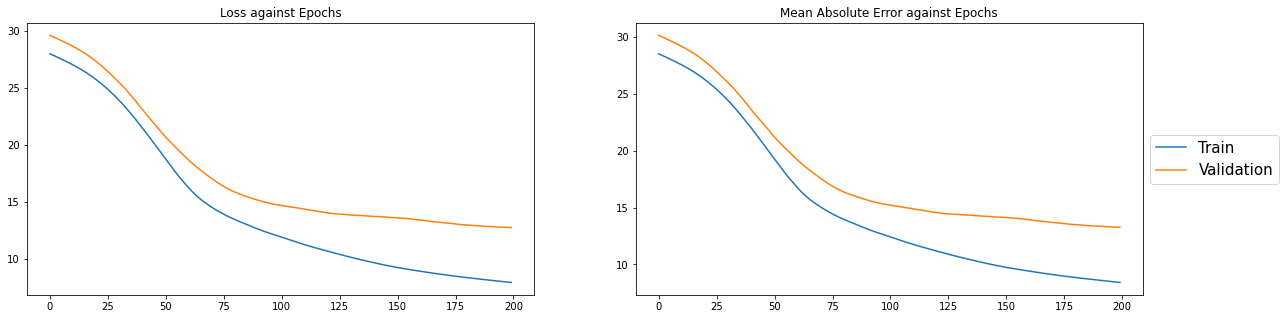

In [447]:
mdl, test_ds = regression([75, 100, 1], 256, 200)

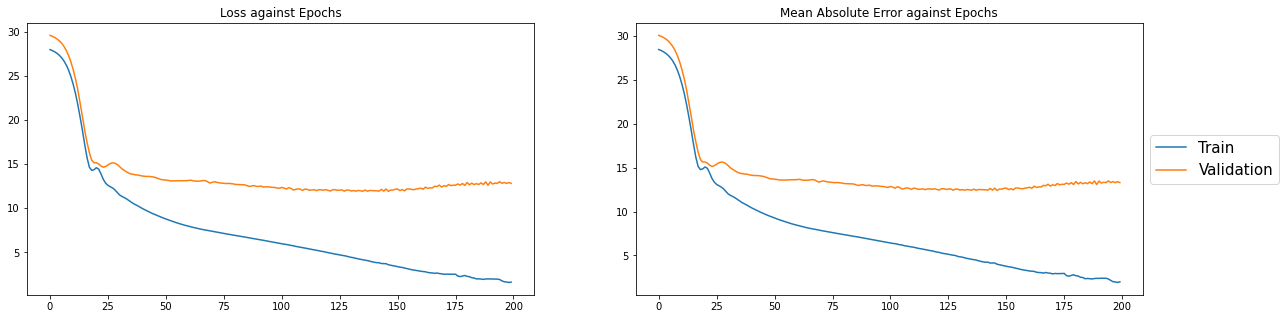

In [448]:
mdl, test_ds = regression([75, 100, 100, 100, 1], 256, 200)

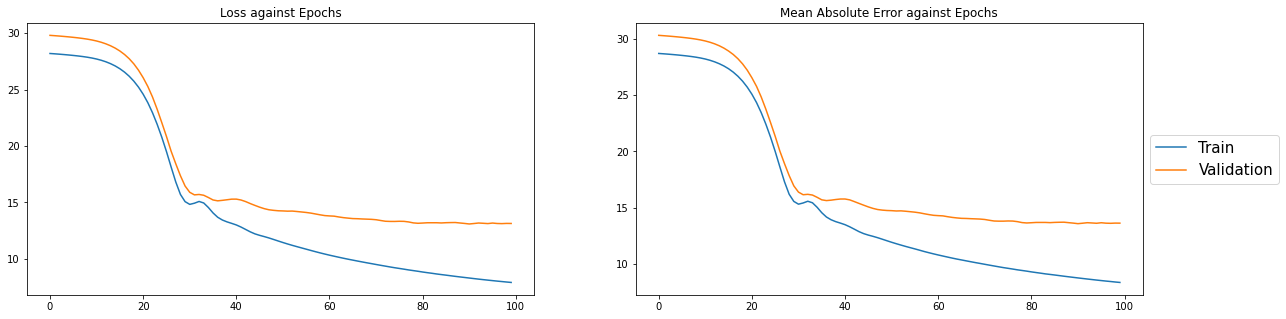

In [449]:
mdl, test_ds = regression([75, 50, 25, 10, 25, 50, 1], 256, 100)

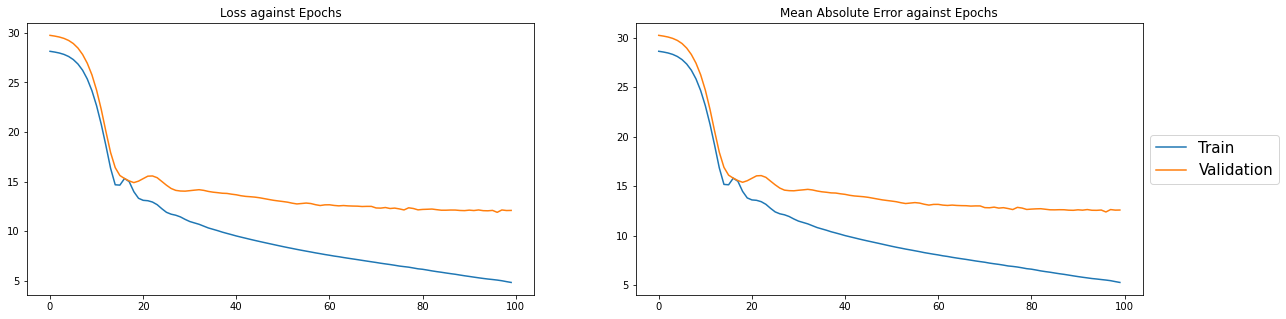

In [450]:
mdl, test_ds = regression([75, 100, 100, 100, 100, 1], 256, 100)

**The models are all quite poor, all having an average MAE of ~13.**